<div style="text-align: center;">
  <h1><b>Modelo de inteligencia artificial de PawSense</b></h1>
  <img src="https://muyinteresante.okdiario.com/wp-content/uploads/sites/5/2022/10/13/634813cd2ab89.jpeg" width="800" height="525">
</div>

PawSense es una aplicación que utiliza la inteligencia artificial para predecir, con la mayor precisión posible, la mezcla de razas de tu perro. 

Es una herramienta pensada tanto para organizaciones como protectoras, refugios y veterinarias, donde puede ser útil para entender mejor los cuidados de un perro e incluso prevenir futuras enfermedades a las que pueden ser propensos, como para usuarios particulares que tienen curiosidad por saber las razas y características que estas implican para su mascota.

<br>

Para llevar a cabo este proyecto hemos utilizado la base de datos de Kaggle 'Stanford Dogs Dataset' que contiene mas de 20,000 imágenes de 120 razas.

Enlace a dataset de Kaggle: <https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset>

<br>

Para ello hemos basado la estrategia de aprendizaje de el modelo en la mejor forma de predecir las razas de un perro según el artículo de **La Vanguardia**.

Enlace al artículo: <https://www.lavanguardia.com/mascotas/20220215/8055065/descubre-mezcla-perro-mestizo-nbs.html>.

El artículo se basa en que los perros no son una mezcla aleatoria, sino que contienen rasgos físicos heredados de sus antepasados; por tanto, la mejor forma de predecir esto es basarnos en su fisionomía. Para ello, hemos diseñado un modelo entrenado a través de redes neuronales, permitiendo ajustar el aprendizaje en distintas capas para que el modelo se base lo máximo posible en la fisionomía del perro.

El artículo se basa en estudios de genética canina de alto nivel respaldados por una universidad de Hungría (Universidad Eötvös Loránd).

<br>

Para el mejor desempeño del modelo, hemos diseñado una estrategia que se ajusta lo máximo posible a este artículo y al rendimiento del modelo según nuestros recursos y conceptos. Este proceso lo hemos dividido en 7 fases:

- **Fase 1**: Preparación del entorno.

- **Fase 2**: Ingeniería de datos.
 
- **Fase 3**: Visualización de datos e imágenes.

- **Fase 4**: Preprocesamiento y aumento.

- **Fase 5**: Construcción del modelo.

- **Fase 6**: Entrenamiento del modelo.

- **Fase 7**: Evaluación y conclusiones.

#### Alumnos:
- Victor Jiménez Guerrero
- Enrique Moreno Alcántara
- Carlos Cerezo López

## Fase 1: Preparación del entorno

Importamos las bibliotecas que vamos usar en el cuaderno.

- **os**: Interactuar con sistema operativo.

- **torch**: Modelo de redes neuronales.

- **xml.etree.ElementTree**: Obtener datos de archivo xml.

- **glob**: Búsqueda de archivos y directorios.

- **PIL**: Abrir, convertir, redimensionar y guardar imágenes (cargar fotos para procesarlas).

- **matplotlib**: Crear gráficos y visualizaciones (mostrar imágenes, curvas de pérdida/accuracy, etc.).

- **numpy**: Operaciones numéricas con arrays/matrices (normalizar datos, cálculos rápidos).

- **tqdm**: Barra de progreso para bucles largos (entrenamiento/procesamiento masivo).

- **json**: Leer y escribir datos en formato JSON (configuraciones, etiquetas, resultados).

- **sklearn.metrics**: Calcular la matriz de confusión para evaluar un clasificador.

- **seaborn**: Visualización estadística con gráficos más estéticos (p. ej., heatmap de la matriz de confusión).

- **collections**: Manipular colecciones.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import xml.etree.ElementTree as ET
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from collections import Counter

# Preparación del entorno (GPU RTX 3060)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🚀 GPU detectada: {torch.cuda.get_device_name(0)}")
    # Optimizador de kernels para Windows/NVIDIA
    torch.backends.cudnn.benchmark = True

✅ Usando dispositivo: cuda
🚀 GPU detectada: NVIDIA GeForce RTX 3060


## Fase 2: Ingeniería de datos.

Observamos que el dataset de kaggle contiene la carpeta 'annotations' la cual contiene archivos xml referenciados a cada foto con respectivas medidas de los perros. 

Por tanto, aplicamos recorte en las imágenes para que el modelo aprenda exclusivamente de los perros no de otros posibles objetos de la foto (coches, personas, árboles, etc).

In [4]:
# Listas almacena variables para gráficas
todas_las_razas = []
datos_proporcion = []
aspect_ratios = []

# Patron buscar subcarpetas
xml_pattern = r"dataset_perros/annotations/Annotation/**/*"

# Para cada path parsea arquitectura xml y de ahi obtenemos desde la raiz las medidas del perro en las imagenes
for xmlpath in glob.glob(xml_pattern, recursive=True):
    # Para que no se salga de la carpeta
    if os.path.isdir(xmlpath):
        continue

    try:
        # Estructura, raiz y objeto
        tree = ET.parse(xmlpath)
        root = tree.getroot()
        obj = root.find('object')

        if obj is not None:

            # Sacamos medidas del perro en la foto
            box = obj.find('bndbox')
            raza = obj.find('name').text

            xml_w = int(root.find('size/width').text)
            xml_h = int(root.find('size/height').text)

            xmin = int(box.find('xmin').text)
            xmax = int(box.find('xmax').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)

            # Variables a almacenar para las gráficas
            todas_las_razas.append(raza)
            area_perro = (xmax - xmin) * (ymax - ymin)
            area_total = xml_w * xml_h
            porcentaje = (area_perro / area_total) * 100
            datos_proporcion.append(porcentaje)
            aspect_ratios.append(xml_w / xml_h)

            # En vez de coger el nombre del xml (había xml con nombres distinto del nombre de archivos de imágenes) lo coge directamente del archivo
            xml_filename = os.path.basename(xmlpath)
            imgname = os.path.splitext(xml_filename)[0] # Nombre archivo sin extension

            # El nombre de la carpeta padre del xml debe coincidir con la carpeta de la imagen
            imgfoldername = os.path.basename(os.path.dirname(xmlpath))

            # Patron para buscar imágenes por carpeta e imagen obtenida del nombre del archivo
            img_pattern = rf"dataset_perros/images/Images/{imgfoldername}/{imgname}.jpg"

            encontrados = glob.glob(img_pattern)
            if not encontrados:
                print(f"Procesando archivo: {xmlpath}")
                print(f"❌ No se encontró imagen para: {imgname} en {imgfoldername}")

            # Para cada path abre la imagen, asegura de que este en colores, redimensiona a lo especificado en cml (por si acaso), reajusta calidad y recorta la imágen.
            for imgpath in glob.glob(img_pattern, recursive=True):
                img = Image.open(imgpath).convert('RGB')

                # Reajustar medidas de imagen para evitar problemas de recorte
                width, height = img.size
                if width != xml_w or height != xml_h:
                    img = img.resize((xml_w, xml_h), Image.LANCZOS)

                # Recorte de imágen
                img_final = img.crop((xmin, ymin, xmax, ymax)).resize((224, 224), Image.LANCZOS)

                # Crea directorio con carpetas de nombres de raza
                output_dir = os.path.join("dataset_recortado", raza)
                os.makedirs(output_dir, exist_ok=True)

                # Guarda imágenes
                save_path = os.path.join(output_dir, f"{imgname}.jpg")
                img_final.save(save_path)
    except Exception as e:
        print(f"Saltando {xmlpath} por error: {e}")

## Fase 3: Visualización de datos e imágenes.

- Fotos antes y despues del recortado

- Gráfico de barras del top 10 y bottom 10 de razas para ver si hay desequilibrio.

- Gráfico de ocupación del perro en la imágen.

- Gráfica de relación de aspecto original.

- Área del perro vs tamaño de imagen original

### Fotos antes y despues del recortado.

<function matplotlib.pyplot.show(close=None, block=None)>

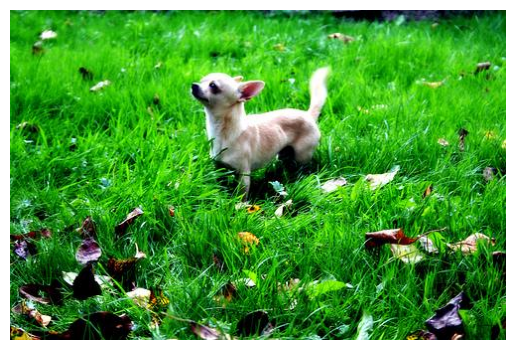

In [5]:
img_normal = Image.open(r"dataset_perros\images\Images\n02085620-Chihuahua\n02085620_275.jpg")
plt.imshow(img_normal)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

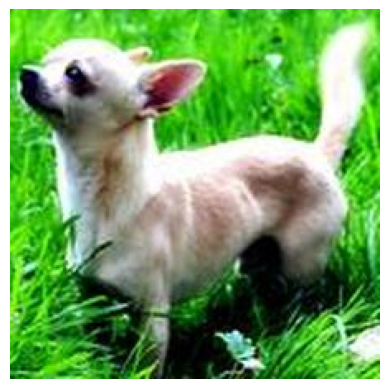

In [6]:
img_recortada = Image.open(r"dataset_recortado\Chihuahua\n02085620_275.jpg")
plt.imshow(img_recortada)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

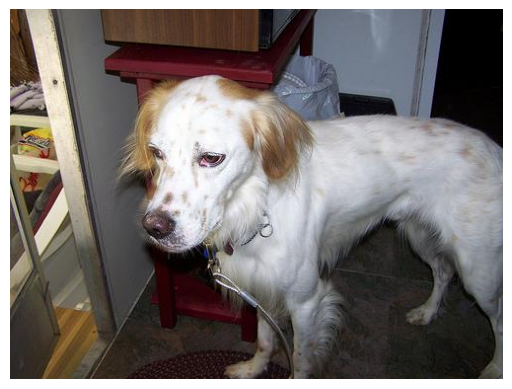

In [15]:
img_normal2 = Image.open(r"dataset_perros\images\Images\n02100735-English_setter\n02100735_9914.jpg")
plt.imshow(img_normal2)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

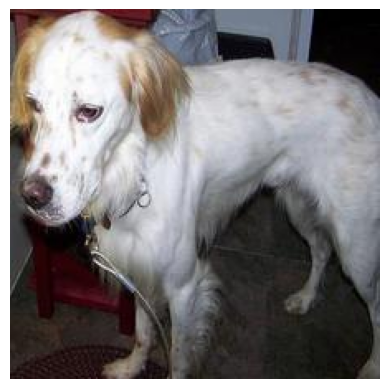

In [14]:
img_recortada2 = Image.open(r"dataset_recortado\English_setter\n02100735_9914.jpg")
plt.imshow(img_recortada2)
plt.axis("off")
plt.show

### Gráfico de barras del top 10 y bottom 10 de razas para ver si hay desequilibrio.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_15808\3670861702.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts.head(10), x='Cantidad', y='Raza', palette='viridis', ax=ax1)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_15808\3670861702.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts.tail(10), x='Cantidad', y='Raza', palette='magma', ax=ax2)


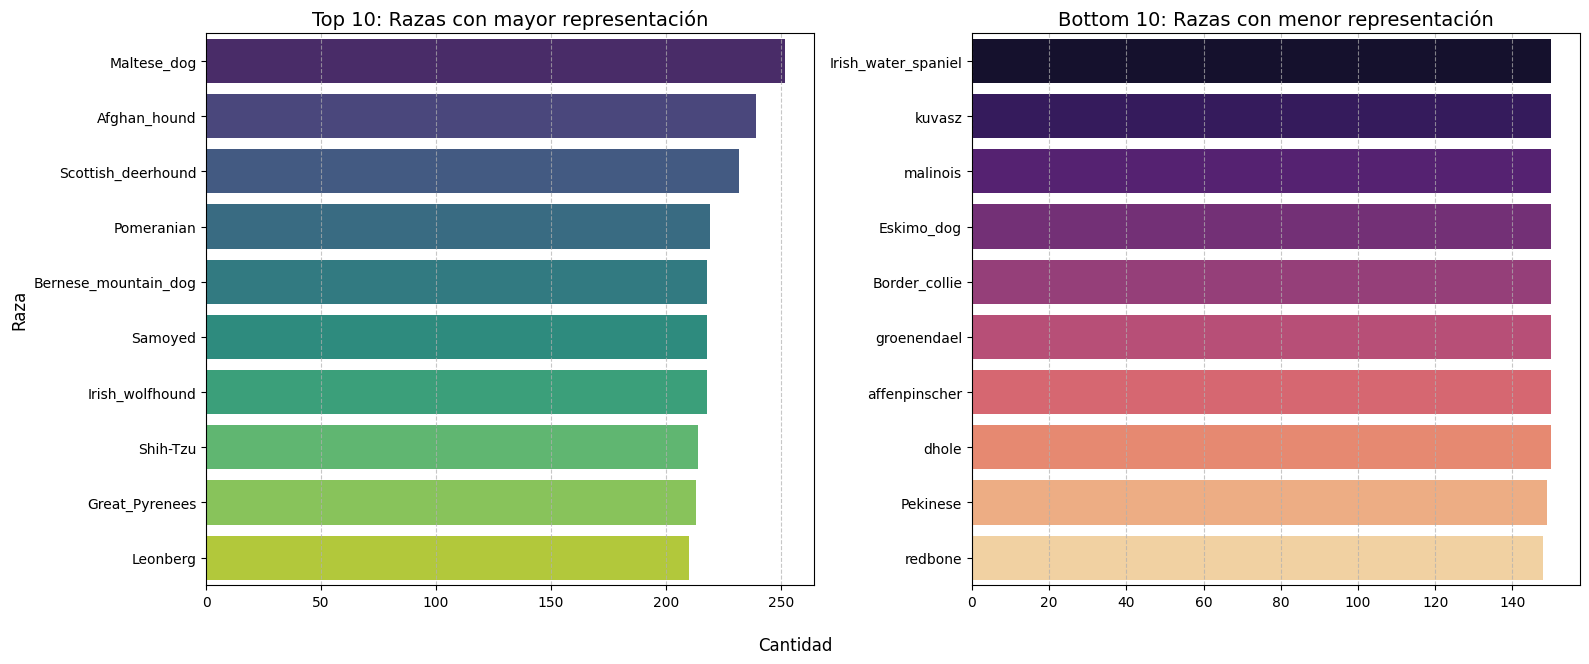

In [7]:
# Preparar el DataFrame
conteo_razas = Counter(todas_las_razas)
df_counts = pd.DataFrame(conteo_razas.items(), columns=['Raza', 'Cantidad']).sort_values(by='Cantidad', ascending=False)

# Creamos la figura con 2 subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Gráfico Top 10 (Izquierda) ---
sns.barplot(data=df_counts.head(10), x='Cantidad', y='Raza', palette='viridis', ax=ax1)
ax1.set_title('Top 10: Razas con mayor representación', fontsize=14)
ax1.set_ylabel('Raza', fontsize=12) # Solo aparece aquí
ax1.set_xlabel('') # Quitamos la individual
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# --- Gráfico Bottom 10 (Derecha) ---
sns.barplot(data=df_counts.tail(10), x='Cantidad', y='Raza', palette='magma', ax=ax2)
ax2.set_title('Bottom 10: Razas con menor representación', fontsize=14)
ax2.set_ylabel('') # Quitamos la etiqueta central para que no se repita
ax2.set_xlabel('') # Quitamos la individual
ax2.grid(axis='x', linestyle='--', alpha=0.7)

# --- Configuración global ---
# Añadimos "Cantidad" una sola vez en el centro inferior
fig.text(0.5, 0.02, 'Cantidad', ha='center', va='center', fontsize=12)

# Ajustamos el layout para que no se solapen y dejamos espacio abajo para la etiqueta común
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

Muestra las razas de las que mas y menos información (imágenes) tiene. Todas están dentro de un rango parecido pero podría indicar la raza por la cual existe la posibilidad que el modelo tienda a inclinarse.

### Gráfico de ocupación del perro en la imágen.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_15808\4030845478.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x='Area_Porcentaje', y='Raza', palette='muted', errorbar=None)


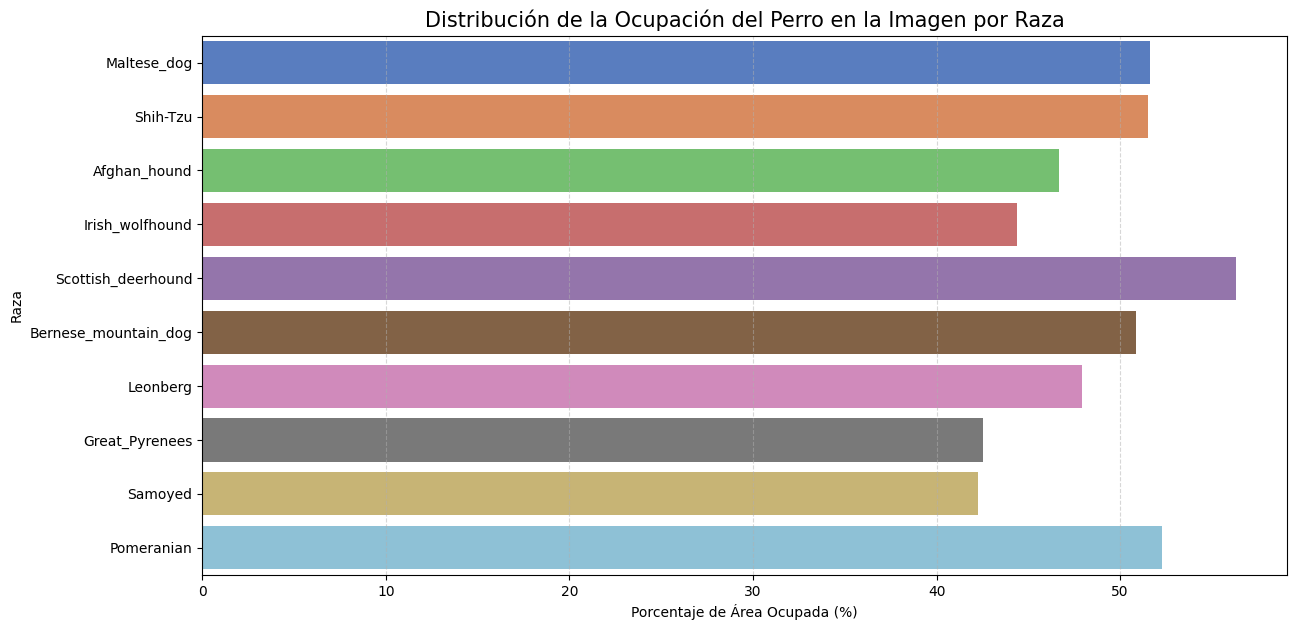

In [8]:
# 1. Crear DataFrame seguro uniendo las listas de tu Fase 2
df_medidas = pd.DataFrame(
    list(zip(todas_las_razas, datos_proporcion)), 
    columns=['Raza', 'Area_Porcentaje']
)

# 2. Seleccionamos las 10 razas con más muestras para que el gráfico sea limpio
top_10_razas = df_medidas['Raza'].value_counts().nlargest(10).index
df_top = df_medidas[df_medidas['Raza'].isin(top_10_razas)]

# 3. Gráfico de Violín: Distribución del área por raza
plt.figure(figsize=(14, 7))
sns.barplot(data=df_top, x='Area_Porcentaje', y='Raza', palette='muted', errorbar=None)

plt.title('Distribución de la Ocupación del Perro en la Imagen por Raza', fontsize=15)
plt.xlabel('Porcentaje de Área Ocupada (%)')
plt.ylabel('Raza')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

La gráfica de ocupación demuestra que, antes del procesamiento, el perro solo representaba entre el 40% y el 55% de la imagen. Concluyendo que el recortado de imágenes es eficaz ya que:

- **Elimina el ruido ambiental**

- **Evita el sesgo de escala**: Impide que el modelo aprenda de forma errónea que una raza es "pequeña" o "grande" basándose solo en su tamaño dentro de la imágen ya que sería ambiguo.

### Gráfica de relación de aspecto original y gráfica de área del perro vs tamaño de imagen original

En el siguiente fragmento de código tendremos 2 gráficas

* **Geometría de entrada de la imágen**: La gráfica de **relación de aspecto** nos mostrará la forma en la que la foto se realizó originalmente, la línea marca el equilibrio (1:1), los valores mayores a 1 indican fotos horizontales y menores a 1 verticales.

* **Densidad de información**: La gráfica muestra como de "presente" está el perro en la imágen, esto nos ayuda a preveer si el modelo tiene dificultades detectando objetos muy pequeños (la gráfica es de los datos antes del recortado)

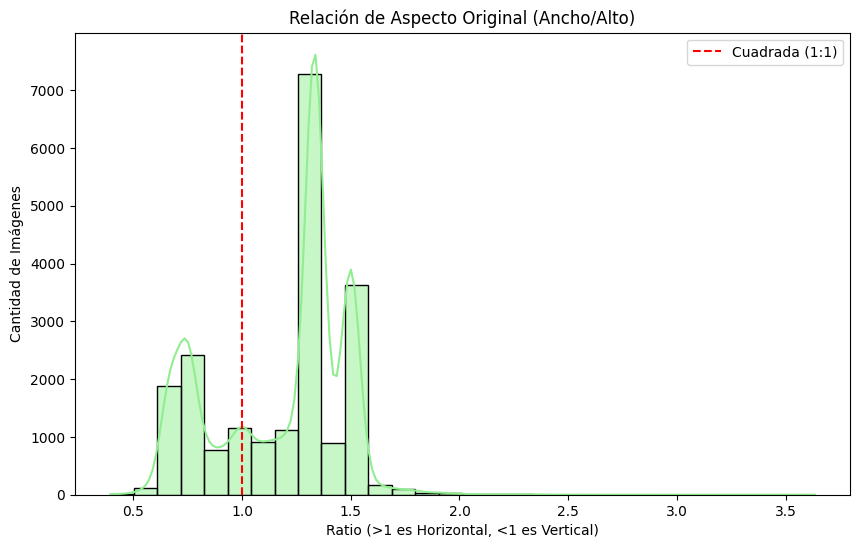

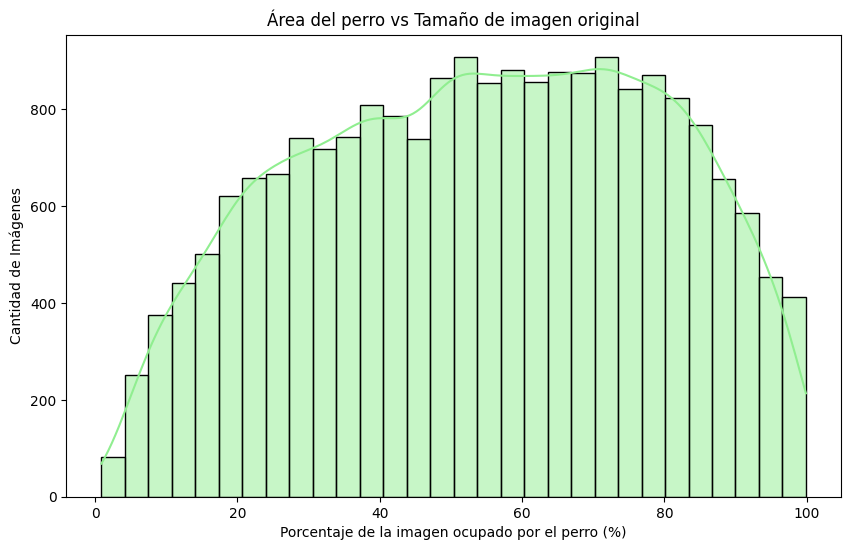

In [9]:
#----- Grafica 1 relacion de aspecto original
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, kde=True, color="lightgreen")
plt.axvline(1, color='red', linestyle='--', label='Cuadrada (1:1)')
plt.title('Relación de Aspecto Original (Ancho/Alto)')
plt.xlabel('Ratio (>1 es Horizontal, <1 es Vertical)')
plt.ylabel('Cantidad de Imágenes')
plt.legend()
plt.show() 


#------ Grafica 2 area del perro
plt.figure(figsize=(10, 6))
sns.histplot(datos_proporcion, bins=30, kde=True, color="lightgreen")
plt.title('Área del perro vs Tamaño de imagen original')
plt.xlabel('Porcentaje de la imagen ocupado por el perro (%)')
plt.ylabel('Cantidad de Imágenes')
plt.show()

## Fase 4: Preprocesamiento y Aumento

En la fase de preprocesamiento realizaremos varias operaciones:

1. **Batch_Size:** Esto significa que el modelo actualizará sus parámetros internos cada vez que procesen un grupo de 64 imágenes.

2. **Data Augmentation:** Aplicamos transformaciones aleatorias de las imágenes durante el entrenamiento (giros aleatorios, ajustes de contraste...). El objetivo es evitar el overfitting y que el modelo "aprenda" las fotos

3. **Conversión y Normalización:** Tomamos el resultado de las transformaciones anteriores y lo convertimos en un tensor (convertir entre 0 y 1), posteriormente realizamos la normalización usando la media de los colores RGB (primera parte) y la desviación estandar (segunda parte)

4. **Carga y separación:** Cargamos el dataset con **datasets.ImageFolder** que escanea las carpetas y etiqueta las imágenes automáticamente y dividimos los datos en 80% entrenamiento y 20% validación

5. **Aplicamos transformaciones:** Barajamos el dataset para que la mezcla de razas sea aleatoria y aplicamos las rotaciones solo a las imágenes de entrenamiento. La parte de validación se mantiene igual para evaluar el modelo con fotos reales.

6. **Cargamos los datos finales para el entrenamiento**: Hacemos uso de DataLoader para cargar ya los datos al modelo.

In [3]:
batch_size = 32

# Preprocesamiento y Data Augmentation de Train
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización ImageNet
])

# Normalización de datos de validación
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cargar dataset y dividir
full_dataset = datasets.ImageFolder("dataset_recortado")
train_size = int(0.8 * len(full_dataset)) # 80%
val_size = len(full_dataset) - train_size # 20%

# Aplicar transformaciones por separado
indices = torch.randperm(len(full_dataset)).tolist()
train_ds = Subset(datasets.ImageFolder("dataset_recortado", transform=train_transforms), indices[:train_size])
val_ds = Subset(datasets.ImageFolder("dataset_recortado", transform=val_transforms), indices[train_size:])

# Carga de datos final para el entrenamiento
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Fase 5: Construcción del Modelo

+ Base: Usamos EfficientNetB0 como capa base para realizar el entrenamiento.
+ Dropout (0.3): Apaga aleatoriamente el 20% de las neuronas para evitar que el modelo memorice las fotos (previene el overfitting).
+ Linear (Salida EfficientNetB0, 120): Unimoz los datos de entrada (neuranas de salida de EfficientNetB0) con nuestra salida 120 correspondiente a cada raza.



In [ ]:
print("Cargando EfficientNetB0...")
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Congelar base
for param in model.parameters():
    param.requires_grad = False

# Personalizar la cabeza (120 razas)
# Primero, obtenemos cuántos datos salen del cuerpo del modelo (son 1280 en EfficientNetB0)
num_ftrs = model.classifier[1].in_features

model.classifier[1] = nn.Sequential(
    # Apaga aleatoriamente el 20% de las neuronas para evitar que el modelo memorice las fotos (previene el overfitting)
    nn.Dropout(p=0.3, inplace=True),
    # Conecta los 1280 datos de entrada con nuestras 120 salidas
    nn.Linear(num_ftrs, 120)
)
model = model.to(device)

Cargando EfficientNetB0...


# Resumen de parámetros
Mostramos un pequeño resumen del número de parámetros totales de nuestra red neuronal.

In [5]:
from torchinfo import summary
# Batch size, Channels, Height, Width
summary(model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], verbose=0)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

# Implementación de Early Stopping
Creamos una clase llamada EarlyStopping, para que en caso de que el modelo no mejora después de una cantidad determinada de épocas pare el entrenamiento.

In [6]:
class EarlyStopping:
    """Para el entrenamiento si la valid loss no mejora después de 'patience' épocas."""
    def __init__(self, patience=5, min_delta=0, path='modelo_perros.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Guarda el modelo cuando la validation loss disminuye.'''
        torch.save(model.state_dict(), self.path)

# Fase 6: Entrenamiento en Dos Etapas
Etapa A: Calentamiento (Transfer Learning)
+ Acción: congelamos el modelo base.
+ Optimizer: Adam con Learning Rate alto $(10^{-3})$.
+ Épocas: 5-8.


Etapa B: Ajuste Fino (Fine-Tuning)
+ Acción: Descongelamos la capa base.
+ Optimizer: Adam con Learning Rate bajísimo $(10^{-5})$.
+ Épocas: 20-30.


## Definición de función de entrenamiento
En primer lugar definimos la regla de medida del error (Loss Function), en nuestro caso Entropia Cruzada (Cross Entropy Loss).

Definimos que use nuestra GPU como escalador para usar precisión mixta, se explicará en otro párrafo. Además inicializamos un diccionario para posteriormente guardar los resultados de cada ciclo y poder mostrar gráficas al respecto.

Dentro de la función ponemos el modelo en modo entrenamiento, activando el Dropout, además añdimos una utilidad para ver el progreso de cada época.
Una vez empezamos a cargar las imagenes en memoria, nos aseguramos de limpiar los gradientes anteriores para no acumular errores.
* Sin zero_grad(): El optimizador daría un paso basado en la suma de los errores actuales y pasados, lo cual arruinaría el entrenamiento (el modelo no convergería porque "arrastra" información vieja).

* Con zero_grad(): Te aseguras de que cada paso de optimización se base únicamente en el error del lote (batch) de datos actual.

A continuación, iniciamos la precisión mixta, normalmente, los modelos de PyTorch operan en Float32 (precisión simple). La Precisión Mixta consiste en utilizar dos formatos distintos durante el entrenamiento:
* Float16 ($FP16$): Para la mayoría de las operaciones (como las multiplicaciones de matrices en las capas densas o convolucionales). Es mucho más rápido en GPUs modernas.
* Float32 ($FP32$): Para operaciones críticas que requieren mucha exactitud (como el cálculo de la función de pérdida o la actualización de pesos), manteniendo la estabilidad del modelo.

Tras esto nos aseguramos que el modelo escala los número de Float32 a Float16 y viceversa de forma apropiada y nos aseguramos que solo se actualizen los pesos (llamar al optimizador) si no ocurre un error en le proceso.

Finalmente, mostramos la estadísticas de avance en vivo. Nos aseguramos de devolver  el promedio de pérdida y precisión de  la época. 

In [ ]:
criterion = nn.CrossEntropyLoss() # Definimos la "regla de medida" del error (Loss Function)
# Activamos el Escalador de Gradientes para Precisión Mixta (AMP)
# permite que la GPU use menos memoria y trabaje más rápido sin perder precisión en el entrenamiento.
scaler = torch.amp.GradScaler('cuda') 
# Almacenamos la pérdida y la exactitud para luego dibujar las gráficas.
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def train_epoch(model, loader, optimizer, scaler, epoch_idx):
    """Función para entrenar el modelo durante una época completa"""

    # Ponemos el modelo en modo entrenamiento (activa Dropout)
    model.train()
    running_loss, correct = 0.0, 0

    # Envolver el loader con tqdm para ver el progreso por batch
    pbar = tqdm(loader, desc=f"Epoch {epoch_idx} [TRAIN]", unit="batch")
    
    for images, labels in pbar:

        images, labels = images.to(device), labels.to(device) # Movemos los datos a la memoria de la GPU

        optimizer.zero_grad() # Limpiamos los gradientes anteriores para no acumular errores

        # --- Inicio de Precisión Mixta ---
        with torch.amp.autocast('cuda'):
            outputs = model(images) # El modelo hace su predicción (Forward Pass)
            loss = criterion(outputs, labels) # Calculamos qué tan equivocado estuvo (Loss)

        #El escalador ajusta la pérdida para que sea compatible con la precisión de la GPU
        # y luego calculamos la dirección del error (Backpropagation)
        scaler.scale(loss).backward()

        scaler.step(optimizer) # El optimizador da un "paso" y ajusta los pesos del modelo
        scaler.update() # Actualizamos el escalador para el siguiente lote
        
        # --- Estadísticas en vivo ---
        running_loss += loss.item()
        _, pred = outputs.max(1) # Obtenemos la raza con mayor probabilidad
        correct += pred.eq(labels).sum().item() # Contamos cuántas acertó
        
        # Actualizar información en la barra de progreso
        pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/((pbar.n+1)*loader.batch_size)})

    # Devolvemos el promedio de pérdida y precisión de toda la época    
    return running_loss/len(loader), 100.*correct/len(loader.dataset)



## Definición de función de validación
En este caso tenemos que poner nuestro modelo en modo evaluación, aquí unicamente predecimos. Por lo que podemos desactivar el cáculo de gradiente, es decir, el cáculo de como tiene que modificar cada peso.

Nos aseguramos de devolver los resultados para comparar con el entrenamiento.

In [10]:
def validate_epoch(model, loader):
    """Función para evaluar el modelo sin entrenarlo"""
    # Ponemos el modelo en modo evaluación (desactiva Dropout para mayor estabilidad)
    model.eval() 
    running_loss, correct = 0.0, 0

    # Barra de progreso para la validación (se borra al terminar para no llenar la pantalla)
    pbar = tqdm(loader, desc="Validando", unit="batch", leave=False)

    # Desactivamos el cálculo de gradientes para que la GPU vaya más rápido y use menos RAM
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

           # El modelo solo predice, no aprende aquí
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
    # Devolvemos los resultados para compararlos con los de entrenamiento.        
    return running_loss/len(loader), 100.*correct/len(loader.dataset)

## Etapa A: Calentamiento (Transfer Learning)

El objetivo de esta etapa es entrenar únicamente la nueva "cabeza" que añadimos (las 120 razas) mientras el resto del cuerpo del modelo (EfficientNet) sigue congelado.

Realizaremos 5 ciclos de entrenamiento inicial, que sumado a la siguiente fase nos dará un total de 30 ciclos totales de entrenamiento.

Usaremos el optimizador adam indicandole un leaning rate de $(10^{-3})$ como hemos indicado anteriormente. Nos asuramos de guardar los resultados de cada época para su posterior análisis.

In [8]:
# Configuramos el optimizador Adam
# IMPORTANTE: Solo le pasamos 'model.classifier.parameters()', esto le dice al optimizador que solo puede tocar los pesos de la capa final.
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3) # Usamos un Learning Rate de 1e-3 (0.001), para avanzar rápido.

for epoch in range(5):
    # Ejecutamos la función de entrenamiento para esta época
    # Obtenemos la pérdida (t_loss) y la precisión (t_acc) del entrenamiento.
    t_loss, t_acc = train_epoch(model, train_loader, optimizer, scaler, epoch+1)
    
    # Ejecutamos la validación
    v_loss, v_acc = validate_epoch(model,val_loader)

    # Guardamos los resultados en nuestro diccionario 'history'
    # Esto es lo que permite que después podamos dibujar las gráficas de Accuracy y Loss.
    for k, v in zip(history.keys(), [t_loss, t_acc, v_loss, v_acc]): history[k].append(v)

    # Imprimimos resumen rápido al terminar cada época
    print(f"✅ Final E{epoch+1} - Val Acc: {v_acc:.1f}%")

Epoch 1 [TRAIN]: 100%|██████████| 515/515 [00:26<00:00, 19.24batch/s, loss=2.13, acc=42]  


✅ Final E1 - Val Acc: 59.8%


Epoch 2 [TRAIN]: 100%|██████████| 515/515 [00:23<00:00, 21.55batch/s, loss=1.75, acc=59.4] 


✅ Final E2 - Val Acc: 62.3%


Epoch 3 [TRAIN]: 100%|██████████| 515/515 [00:22<00:00, 22.43batch/s, loss=2.38, acc=62.4] 


✅ Final E3 - Val Acc: 64.9%


Epoch 4 [TRAIN]: 100%|██████████| 515/515 [00:22<00:00, 22.56batch/s, loss=1.66, acc=65]   


✅ Final E4 - Val Acc: 65.9%


Epoch 5 [TRAIN]: 100%|██████████| 515/515 [00:23<00:00, 22.27batch/s, loss=1.16, acc=66.2] 
                                                               

✅ Final E5 - Val Acc: 65.5%


## Etapa B: Ajuste Fino (Fine-Tuning)
Descongelamos las capas superiores del extractor de características (EfficientNet), y usamos un Learning Rate (lr) muy bajo de $10^{-5}$ ($0.00001$).

Nos aseguramos de usar un scheduler, para reducir el ratio de aprendizaje (LR) si se estanca. Activamos el EarlyStopping y usamos el optimizador Adam.

Realizamos 25 ciclos de entrenamiento con su correspondiente validación, además de guardar los resultados para su posterior anális. Tendremos que verificar el Early Stopping al cuál le hemos indicado una paciencia de 5, es decir, se activará si en 5 ciclos no se observa mejora en el modelo.

In [9]:
# Stage B: Fine-Tuning
print("Fase 6B: Ajuste Fino...")

# Descongelamos todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = True

# Optimizador con learning rate muy bajo para no romper lo aprendido
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Scheduler para reducir el LR si nos estancamos (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# Early Stopping para detener si no mejoramos
early_stopping = EarlyStopping(patience=5, path='modelo_perros_pytorch.pth')

epochs = 25 # Aumentamos las épocas permitidas

for epoch in range(epochs):
    # Entrenar
    t_loss, t_acc = train_epoch(model, train_loader, optimizer, scaler, epoch+1)
    
    # Validar
    v_loss, v_acc = validate_epoch(model, val_loader)
    
    # Guardar historial
    for k, v in zip(history.keys(), [t_loss, t_acc, v_loss, v_acc]): history[k].append(v)
    
    # Mostrar métricas
    print(f"✅ Final FT{epoch+1} - Val Acc: {v_acc:.1f}% | Val Loss: {v_loss:.4f}")
    
    # Actualizar Scheduler
    scheduler.step(v_loss)
    
    # Verificar Early Stopping
    early_stopping(v_loss, model)
    if early_stopping.early_stop:
        print(f"⏹️ Early Stopping activado en la época {epoch+1}")
        break

# Cargar el mejor modelo guardado por EarlyStopping
model.load_state_dict(torch.load('modelo_perros_pytorch.pth'))
print("Mejor modelo cargado.")


Fase 6B: Ajuste Fino...


Epoch 1 [TRAIN]: 100%|██████████| 515/515 [00:47<00:00, 10.90batch/s, loss=0.82, acc=72]   


✅ Final FT1 - Val Acc: 73.3% | Val Loss: 0.9191


Epoch 2 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.78batch/s, loss=0.8, acc=76.6]  


✅ Final FT2 - Val Acc: 75.8% | Val Loss: 0.8124


Epoch 3 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.78batch/s, loss=0.91, acc=78.8] 


✅ Final FT3 - Val Acc: 76.9% | Val Loss: 0.7557


Epoch 4 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.80batch/s, loss=0.601, acc=80.3]


✅ Final FT4 - Val Acc: 78.0% | Val Loss: 0.7117


Epoch 5 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.79batch/s, loss=0.575, acc=81.2]


✅ Final FT5 - Val Acc: 78.9% | Val Loss: 0.6772


Epoch 6 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.75batch/s, loss=0.637, acc=81.8]


✅ Final FT6 - Val Acc: 80.0% | Val Loss: 0.6474


Epoch 7 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.79batch/s, loss=0.564, acc=82.8]


✅ Final FT7 - Val Acc: 80.8% | Val Loss: 0.6250


Epoch 8 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.61batch/s, loss=0.299, acc=83.4]


✅ Final FT8 - Val Acc: 80.6% | Val Loss: 0.6191


Epoch 9 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.82batch/s, loss=0.431, acc=84.4]


✅ Final FT9 - Val Acc: 81.8% | Val Loss: 0.5943


Epoch 10 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.78batch/s, loss=0.336, acc=84.8]


✅ Final FT10 - Val Acc: 81.2% | Val Loss: 0.5968


Epoch 11 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.68batch/s, loss=0.552, acc=85.1]


✅ Final FT11 - Val Acc: 81.7% | Val Loss: 0.5843


Epoch 12 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.89batch/s, loss=0.78, acc=86.1] 


✅ Final FT12 - Val Acc: 82.3% | Val Loss: 0.5587


Epoch 13 [TRAIN]: 100%|██████████| 515/515 [00:45<00:00, 11.40batch/s, loss=0.443, acc=86.5]


✅ Final FT13 - Val Acc: 82.6% | Val Loss: 0.5497


Epoch 14 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.71batch/s, loss=0.516, acc=87.2]


✅ Final FT14 - Val Acc: 82.7% | Val Loss: 0.5540


Epoch 15 [TRAIN]: 100%|██████████| 515/515 [00:45<00:00, 11.33batch/s, loss=0.418, acc=87.4]


✅ Final FT15 - Val Acc: 82.6% | Val Loss: 0.5491


Epoch 16 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.62batch/s, loss=0.82, acc=87.8] 


✅ Final FT16 - Val Acc: 82.9% | Val Loss: 0.5481


Epoch 17 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.71batch/s, loss=0.62, acc=88.5]  


✅ Final FT17 - Val Acc: 82.9% | Val Loss: 0.5475


Epoch 18 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.66batch/s, loss=0.209, acc=88]  


✅ Final FT18 - Val Acc: 82.8% | Val Loss: 0.5383


Epoch 19 [TRAIN]: 100%|██████████| 515/515 [00:45<00:00, 11.37batch/s, loss=1.49, acc=88.5]  


✅ Final FT19 - Val Acc: 82.9% | Val Loss: 0.5420


Epoch 20 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.58batch/s, loss=0.397, acc=89.2] 


✅ Final FT20 - Val Acc: 83.2% | Val Loss: 0.5258


Epoch 21 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.61batch/s, loss=0.688, acc=89.1]


✅ Final FT21 - Val Acc: 83.4% | Val Loss: 0.5212


Epoch 22 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.53batch/s, loss=0.598, acc=89.5]


✅ Final FT22 - Val Acc: 83.5% | Val Loss: 0.5186


Epoch 23 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.69batch/s, loss=0.243, acc=90.2] 


✅ Final FT23 - Val Acc: 83.6% | Val Loss: 0.5218


Epoch 24 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.59batch/s, loss=0.205, acc=90.7] 


✅ Final FT24 - Val Acc: 83.7% | Val Loss: 0.5163


Epoch 25 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.52batch/s, loss=0.23, acc=90.3]  
                                                               

✅ Final FT25 - Val Acc: 83.4% | Val Loss: 0.5132
Mejor modelo cargado.


## Guardamos el modelo

In [ ]:
torch.save(model.state_dict(), "modelo_perros.pth")
with open("class_names.json", "w") as f: json.dump(full_dataset.classes, f)
print("\n✅ Completado. Modelo y gráficas guardados.")


✅ Completado. Modelo y gráficas guardados.


# Fase 7: Evaluación y Conclusiones
En primer lugar he mostrado un gráfico comparativo de la precisión y el la perdida de el entrenamiento y la validación. 
Podemos ver el salto entre las 2 etapas a partir del quinto ciclo, donde la precisión se dispara y la perdida cae en picado.
Hay una brecha de unos 6-7 puntos entre ambas. El modelo se está volviendo demasiado bueno memorizando el ruido de tus datos de entrenamiento y está perdiendo la capacidad de generalizar a datos nuevos.
La curva naranja empieza a subir claramente mientras la azul baja, lo cuál implica overfitting. Aquí todavía es moderado, simplemente el modelo dejó de mejorar en el mundo real.

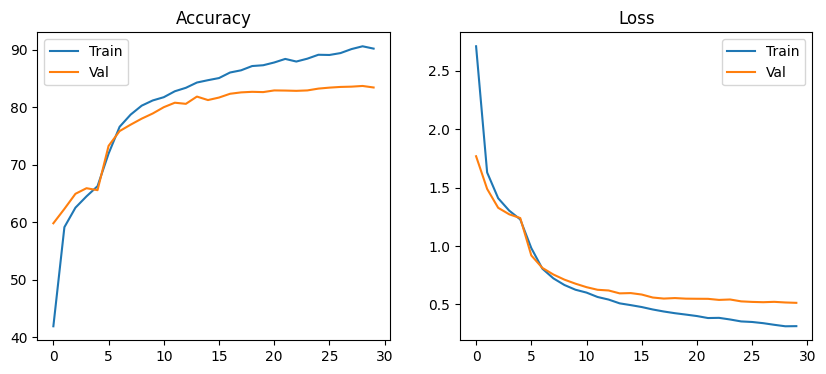

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.legend(); plt.title('Accuracy')
plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.legend(); plt.title('Loss')
plt.savefig('evaluacion/grafica_final.png')
plt.show()

## Matriz de confusión
Hemos creado una matríz de confusión la cuál nos indica las razas que confunde de forma literal entre ellas.

🔍 Generando predicciones para la matriz...


Progreso: 100%|██████████| 129/129 [00:16<00:00,  7.64it/s]


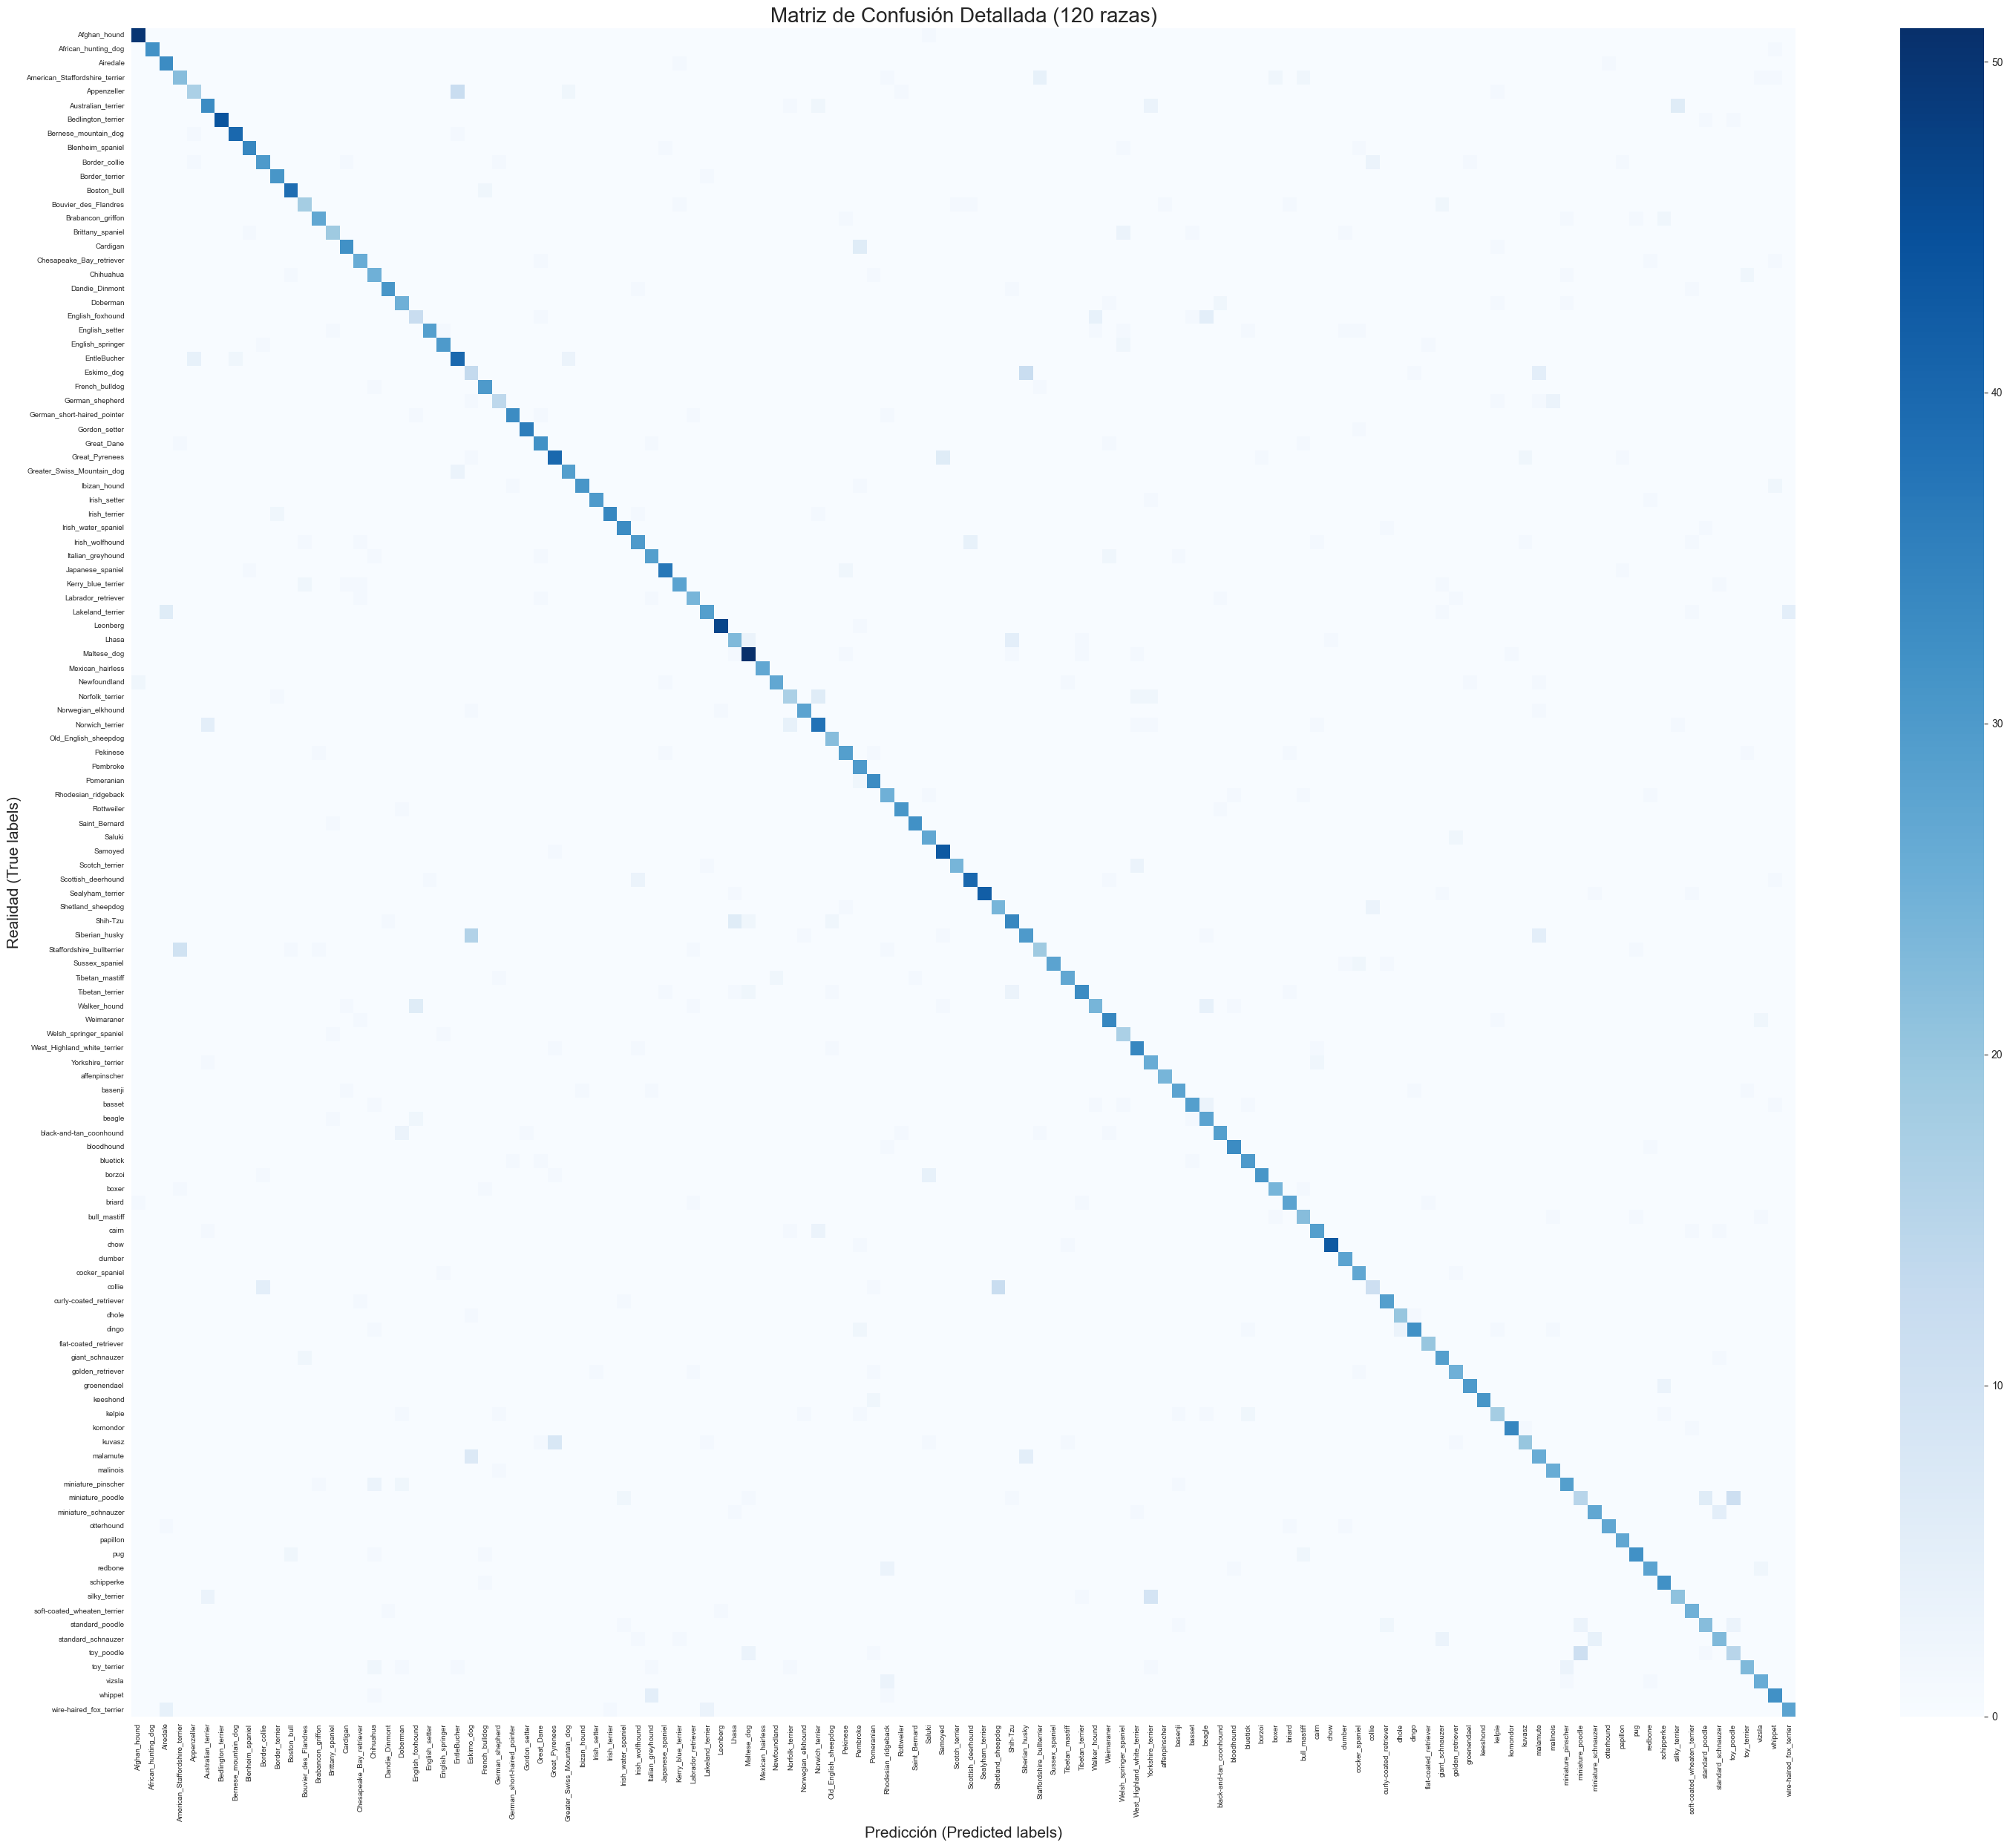

In [17]:
from sklearn.metrics import confusion_matrix

def mostrar_matriz_confusion(model, loader, class_names):
    # 1. Ponemos el modelo en modo evaluación
    model.eval()
    y_true = []
    y_pred = []
    
    # 2. Recolectamos todas las predicciones del set de validación
    print("🔍 Generando predicciones para la matriz...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Progreso"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # 3. Calculamos la matriz con sklearn
    cm = confusion_matrix(y_true, y_pred)
    
    # 4. Visualización con Seaborn
    # Aumentamos ligeramente el ancho para dar espacio a los nombres largos de las razas
    plt.figure(figsize=(30, 25)) 
    
    sns.heatmap(
        cm, 
        annot=False, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names, # ACTIVADO: Muestra nombres en el eje X
        yticklabels=class_names  # ACTIVADO: Muestra nombres en el eje Y
    )
    
    # Ajustamos la rotación y el tamaño de la fuente para que no se amontonen los 120 nombres
    plt.xticks(rotation=90, fontsize=7) 
    plt.yticks(fontsize=7)
    
    plt.title('Matriz de Confusión Detallada (120 razas)', fontsize=20)
    plt.ylabel('Realidad (True labels)', fontsize=15)
    plt.xlabel('Predicción (Predicted labels)', fontsize=15)
    
    # Usamos tight_layout para que los nombres de las razas no se corten al guardar la imagen
    plt.tight_layout()
    plt.savefig('evaluacion/matriz_confusion_nombres.png', dpi=300) # dpi=300 para alta definición
    plt.show()
    
    return y_pred, y_true

# Llamada a la función usando las clases del dataset
y_pred, y_true = mostrar_matriz_confusion(model, val_loader, full_dataset.classes)

Lo mostramos en un dataframe, y lo guardamos en un csv para que este más claro y poder hacer otras estadisticas más facilmente.

In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# 1. Calculamos la matriz numérica (cm)
cm = confusion_matrix(y_true, y_pred)

# 2. Creamos el DataFrame
# Usamos 'full_dataset.classes' para que las filas (Realidad) y 
# las columnas (Predicción) tengan los nombres de las 120 razas.
df_cm = pd.DataFrame(cm, index=full_dataset.classes, columns=full_dataset.classes)

# 3. Guardar a CSV
# Esto es lo más recomendable para poder filtrar y buscar razas en Excel.
df_cm.to_csv("evaluacion/matriz_confusion_perros.csv")
print("Matriz guardada correctamente en 'evaluacion/matriz_confusion_perros.csv'")

# 4. Mostrar las primeras 5 filas en el notebook
df_cm.head()

Matriz guardada correctamente en 'evaluacion/matriz_confusion_perros.csv'


,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,Border_collie,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
Afghan_hound,50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
African_hunting_dog,0,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Airedale,0,0,33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American_Staffordshire_terrier,0,0,0,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Appenzeller,0,0,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Top 15 Razas confundidas
Creamos una gráfica mostrando el Top 15 de las razas que más confunde entre si, y que clasifica incorrectamente.

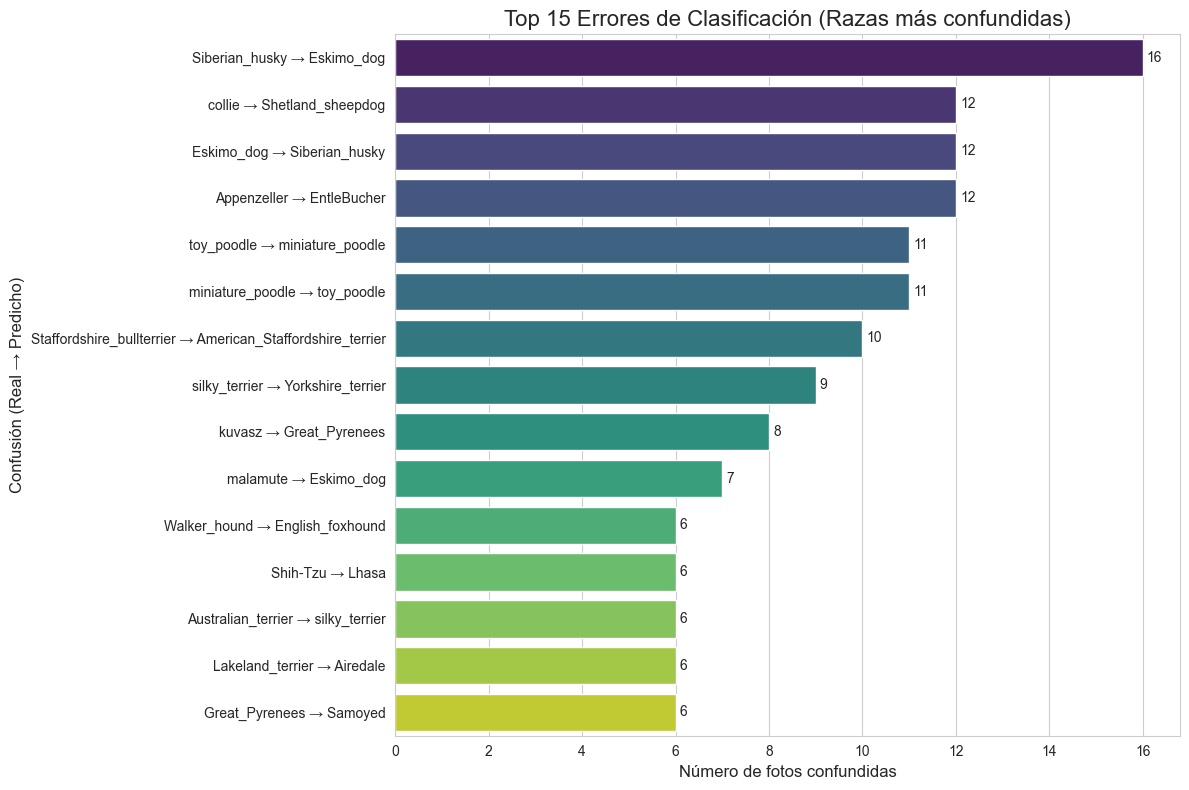

In [15]:

def graficar_mayores_confusiones(y_true, y_pred, class_names, top_n=15):
    # 1. Calculamos la matriz de confusión
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # 2. Convertimos a un DataFrame para manipularlo fácilmente
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # 3. "Limpiamos" la diagonal (ponemos a 0 los aciertos)
    # Solo nos interesan los errores para esta gráfica.
    np.fill_diagonal(cm, 0)
    
    # 4. Extraemos los pares de razas y sus conteos de error
    confusiones = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                confusiones.append({
                    'Real': class_names[i],
                    'Predicho': class_names[j],
                    'Cantidad': cm[i, j],
                    'Pareja': f"{class_names[i]} → {class_names[j]}"
                })
    
    # 5. Ordenamos por cantidad de errores y tomamos los N mejores
    df_confusiones = pd.DataFrame(confusiones).sort_values(by='Cantidad', ascending=False).head(top_n)
    
    # 6. Creamos la gráfica
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Gráfico de barras horizontales
    barras = sns.barplot(
        x='Cantidad', 
        y='Pareja', 
        data=df_confusiones, 
        hue='Pareja',
        palette='viridis'
    )
    
    plt.title(f'Top {top_n} Errores de Clasificación (Razas más confundidas)', fontsize=16)
    plt.xlabel('Número de fotos confundidas', fontsize=12)
    plt.ylabel('Confusión (Real → Predicho)', fontsize=12)
    
    # Añadimos el número exacto al final de cada barra
    for i in barras.containers:
        barras.bar_label(i, padding=3)

    plt.tight_layout()
    plt.savefig('evaluacion/mayores_confusiones.png')
    plt.show()

# Llamada a la función usando los datos obtenidos anteriormente
graficar_mayores_confusiones(y_true, y_pred, full_dataset.classes, top_n=15)

# Reporte de Clasificación
Creamos un reporte con información detallada de la precisión, recall, f1-score de cada raza.

In [16]:
from sklearn.metrics import classification_report

# 1. Generamos el informe como un diccionario en lugar de una cadena de texto
# 'output_dict=True' es la clave para poder pasarlo a un DataFrame.
reporte_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=full_dataset.classes, 
    output_dict=True
)

# 2. Creamos el DataFrame
# Transponemos (.T) para que las razas aparezcan en las filas y las métricas en las columnas.
df_reporte = pd.DataFrame(reporte_dict).T

# 3. Limpieza y formato
# Redondeamos a 2 decimales y ordenamos por 'f1-score' para ver las razas que más fallan primero.
df_reporte = df_reporte.sort_values(by='f1-score', ascending=True)

# 4. Guardar a CSV (opcional pero recomendado)
df_reporte.to_csv("evaluacion/informe_detallado_razas.csv")
print("Informe detallado guardado en 'evaluacion/informe_detallado_razas.csv'")

# 5. Visualizar el Top 10 de razas con más dificultades
df_reporte.head(10)

Informe detallado guardado en 'evaluacion/informe_detallado_razas.csv'


,precision,recall,f1-score,support
Eskimo_dog,0.325000,0.419355,0.366197,31.0
miniature_poodle,0.517241,0.416667,0.461538,36.0
collie,0.647059,0.379310,0.478261,29.0
toy_poodle,0.500000,0.483871,0.491803,31.0
English_foxhound,0.571429,0.521739,0.545455,23.0
Siberian_husky,0.638298,0.555556,0.594059,54.0
Appenzeller,0.739130,0.515152,0.607143,33.0
Staffordshire_bullterrier,0.760000,0.558824,0.644068,34.0
Norfolk_terrier,0.708333,0.607143,0.653846,28.0
American_Staffordshire_terrier,0.647059,0.666667,0.656716,33.0
